<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: Vitaly Radchenko (@vradchenko), [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Sergey Volkov (@sevaspb). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #5. Fall 2018
## <center> RandomForest and Logistic Regression in credit scoring and movie reviews classification

####  Here we will develop and tune models for credit scoring and movies reviews sentiment prediction. Fill the code where needed ("#Your code is here") and answer the questions in the [web form](https://docs.google.com/forms/d/1MS3kW_bjZQAkwwlAjX9G8khj1owq1qc5NQtjzJUvKVo).

For the warm-up, solve the first task.

<font color = 'red'> **Task 1:** </font> There are 7 jurors in the courtroom. Each of them individually can correctly determine whether the defendant is guilty or not with 80% probability. How likely is the jury will make a correct verdict jointly if the decision is made by majority voting?

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q1__*

<font color = 'red'> **Answer options:** </font>
- 20.97%
- 80.00%
- 83.70%
- 96.66%


In [1]:
(0.8)**7 + 7 * (0.8)**6 * 0.2 + 21 * (0.8)**5 * (0.2)**2 + 35*(0.8)**4 * (0.2)**3

0.9666560000000004

In [ ]:
# answer: (4)  

Now let's move directly to machine learning.

#### The [dataset](https://github.com/Yorko/mlcourse.ai/tree/master/data/credit_scoring_sample.csv) looks like this:

##### Target variable
* SeriousDlqin2yrs - the person had long delays in payments during 2 years; binary variable

##### Features
* age - Age of the loan borrower (number of full years); type - integer
* NumberOfTime30-59DaysPastDueNotWorse - the number of times a person has had a delay in repaying other loans more than 30-59 days (but not more) during last two years; type - integer
* DebtRatio - monthly payments (loans, alimony, etc.) divided by aggregate monthly income, percentage; float type
* MonthlyIncome - monthly income in dollars; float type
* NumberOfTimes90DaysLate - the number of times a person has had a delay in repaying other loans for more than 90 days; type - integer
* NumberOfTime60-89DaysPastDueNotWorse - the number of times a person has had a delay in repaying other loans more than 60-89 days (but not more) in the last two years; type - integer
* NumberOfDependents - number of people in the family of the borrower; type - integer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let us implement a function that will replace the NaN values by the median in each column of the table.

In [3]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Reading the data:

In [4]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


View data types of the features:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Look at the distribution of classes in target:

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

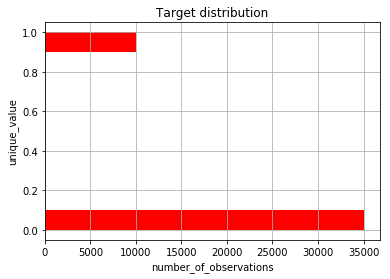

In [7]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Select all the features and drop the target:

In [8]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

We apply a function that replaces all values of NaN by the median value of the corresponding column.

In [15]:
table = impute_nan_with_median(data)

Split the target and features - now we get a training sample.

In [16]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Bootstrap

**<font color = 'red'> Task 2. </font>** Make an interval estimate based on the bootstrap of the average income (MonthlyIncome)  of customers who had overdue loan payments, and of those who paid in time, make 90% confidence interval. Find the difference between the lower limit of the derived interval for those who paid in time and the upper limit for those who are overdue.
So, you are asked to build 90% intervals for the income of "good" customers $ [good\_income\_lower, good\_income\_upper] $ and for "bad" - $ [bad\_income\_lower, bad\_income\_upper] $ and find the difference $ good\_income\_lower - bad\_income\_upper $.

Use the example from the [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7). Set `np.random.seed (17)`. Round the answer to the integer value.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q2__*

In [32]:
data.shape

(45063, 8)

In [33]:
data.head(1)

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0


In [21]:
def get_bootstrap_samples(data, n_samples):
    
    """Generate bootstrap samples using the bootstrap method."""
    
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    
    """Produce an interval estimate."""
    
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [34]:
not_seriousdlqin2yrs = data[data['SeriousDlqin2yrs'] == 0]['MonthlyIncome'].values
yes_seriousdlqin2yrs = data[data['SeriousDlqin2yrs'] == 1]['MonthlyIncome'].values

np.random.seed(17)

not_seriousdlqin2yrs_mean = [np.mean(sample) for sample in get_bootstrap_samples(not_seriousdlqin2yrs, 1000)]
yes_seriousdlqin2yrs_mean = [np.mean(sample) for sample in get_bootstrap_samples(yes_seriousdlqin2yrs, 1000)]

print (stat_intervals(not_seriousdlqin2yrs_mean, 0.1))
print (stat_intervals(yes_seriousdlqin2yrs_mean, 0.1))

[6295.93237577 6505.35467934]
[5471.64826451 5643.93562737]


**<font color='red'>Answer options:</font>**
- 344
- 424
- 584
- 654

In [36]:
6296 - 5644

652

In [ ]:
# Answer (4)

# Decision tree, hyperparameter tuning

One of the main performance metrics of a model is the area under the ROC curve. The ROC-AUC values lay between 0 and 1. The closer the value of ROC-AUC to 1, the better the classification is done.

Find the values of `DecisionTreeClassifier` hyperparameters using the` GridSearchCV`, which maximize the area under the ROC curve.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Use the `DecisionTreeClassifier` class to create a decision tree. Due to the imbalance of the classes in the target, we add the balancing parameter. We also use the parameter `random_state = 17` for the reproducibility of the results.

In [38]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

We will look through such values of hyperparameters:

In [39]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Fix cross-validation parameters: stratified, 5 partitions with shuffle, 
`random_state`.

In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**<font color='red'>Task 3.</font>**
Run GridSearch with the ROC AUC metric using the hyperparameters from the `tree_params` dictionary. What is the maximum ROC AUC value (round up to 2 decimals)? We call cross-validation stable if the standard deviation of the metric on the cross-validation is less than 1%. Was cross-validation stable under optimal combinations of hyperparameters (i.e., providing a maximum of the mean ROC AUC value for cross-validation)?

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q3__*

**<font color='red'>Answer options:</font>**
- 0.82, no
- 0.84, no
- 0.82, yes
- 0.84, yes

In [41]:
grid_tree = GridSearchCV(estimator=dt, 
                         param_grid=tree_params, 
                         cv=skf, 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose=True)

In [42]:
grid_tree.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [44]:
grid_tree.best_score_

0.8203023476209635

In [49]:
grid_tree.cv_results_['mean_test_score'].std() * 100

0.39338499928851217

In [ ]:
# answer (3)

# Simple RandomForest implementation

**<font color='red'>Task 4.</font>**
Implement your own random forest using `DecisionTreeClassifier` with the best parameters from the previous task. There will be 10 trees, the predicted probabilities of which you need to average.

Brief specification:
 - Use the base code below
 - In the `fit` method in the loop (`i` from 0 to `n_estimators-1`), fix the seed equal to (`random_state + i`). The idea is that at each iteration there's a new value of random seed to add more "randomness", but at hte same time results are reproducible
 - After fixing the seed, select `max_features` features **without replacement**, save the list of selected feature ids in `self.feat_ids_by_tree`
 - Also make a bootstrap sample (i.e. **sampling with replacement**) of training instances. For that, resort to `np.choice` and its argument `replace`
 - Train a decision tree with specified (in a constructor) arguments `max_depth`, `max_features` and `random_state` (do not specify `class_weight`) on a corresponding subset of training data. 
 - The `fit` method returns the current instance of the class `RandomForestClassifierCustom`, that is `self`
 - In the `predict_proba` method, we need to loop through all the trees. For each prediction, obviously, we need to take only those features which we used for training the corresponding tree. The method returns predicted probabilities (`predict_proba`), averaged for all trees

Perform cross-validation. What is the average ROC AUC for cross-validation? Select the closest value.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q4__*

**<font color='red'>Answer options:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [50]:
grid_tree.best_params_

{'max_depth': 7, 'max_features': 6}

In [ ]:
def get_bootstrap_samples(data, n_samples):
    
    """Generate bootstrap samples using the bootstrap method."""
    
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    
    """Produce an interval estimate."""
    
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [164]:
np.random.randint(X.shape[1])

3

In [168]:
X.head(2)

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,64,0,0.249908,0,0,8158.0,0.0
1,58,0,3870.000000,0,0,5166.0,0.0


In [170]:
X.iloc[[1,2,3],[1,2,3]]

,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate
1,0,3870.000000,0
2,0,0.456127,0
3,0,0.000190,0


In [ ]:
feat_to_use_ids = np.random.choice(range(X.shape[1]), self.max_features, 
                                              replace=False)

In [190]:
np.random.choice(range(5), 3)

array([1, 3, 0])

In [188]:
features_selected = np.random.randint(low=0, high= X.shape[1], size=np.random.randint(X.shape[1]))
objects_selected = np.random.randint(low=0, high=X.shape[0], size=np.random.randint(X.shape[0]))

In [183]:
features_selected

array([1])

In [184]:
objects_selected

array([  389, 25428, 21211, ..., 12650, 41274, 17119])

In [ ]:
feat_to_use_ids = np.random.choice(range(X.shape[1]), self.max_features, replace=False)

examples_to_use = list(set(np.random.choice(range(X.shape[0]), X.shape[0], replace=True)))

In [195]:
features_selected = np.random.choice(range(X.shape[1]), 10, replace=False)
objects_selected = np.random.choice(range(X.shape[0]), 10, replace=False)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [208]:
features_selected = np.random.choice(range(X.shape[1]), 6, replace=False)

In [211]:
objects_selected = np.random.choice(range(X.shape[0]), X.shape[0], replace=True)

In [212]:
print (features_selected)
print (objects_selected)

[5 1 4 6 0 3]
[ 6823 44164  5333 ... 27610 33742 42808]


In [215]:
dt = DecisionTreeClassifier(class_weight='balanced',
                                        max_depth = 7,
                                        max_features = 6,
                                        random_state=17)

In [219]:
X.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,64,0,0.249908,0,0,8158.0,0.0
1,58,0,3870.000000,0,0,5166.0,0.0
2,41,0,0.456127,0,0,6666.0,0.0
3,43,0,0.000190,0,0,10500.0,2.0
4,49,0,0.271820,0,0,400.0,0.0


In [221]:
X.iloc[[1,2,3],[3,1]]

,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse
1,0,0
2,0,0
3,0,0


In [226]:
dt.fit(X.iloc[objects_selected,features_selected], y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [263]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=10, max_features=10, 
                 random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        for i in range(0, self.n_estimators-1):
            self.random_state = self.random_state + i
            features_selected = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
            objects_selected = np.random.choice(range(X.shape[0]), X.shape[0], replace=True)
            self.feat_ids_by_tree.append(features_selected)
            
            dt = DecisionTreeClassifier(class_weight='balanced',
                                        max_depth = self.max_depth,
                                        max_features = self.max_features,
                                        random_state=self.random_state)
            
            dt.fit(X.iloc[objects_selected, features_selected], y)
            self.trees.append(dt)
        return self
    
    def predict_proba(self, X):
        tree_predictions = []
        for i in range(self.n_estimators):
            tree_predictions.append(self.trees[i].predict_proba(X.iloc[:,self.feat_ids_by_tree[i]]))
        return np.mean(tree_predictions, axis=0)

In [244]:
    def predict_proba(self, X):
        predictions = []
        for i in range(self.n_estimators):
            predictions.append(self.trees[i].predict_proba(X[:,self.feat_ids_by_tree[i]]))
        return np.mean(predictions, axis=0)

In [264]:
rf_classifier_custom = RandomForestClassifierCustom(max_depth = 7, max_features=6).fit(X, y)

In [265]:
cv_aucs = cross_val_score(RandomForestClassifierCustom(max_depth=7, max_features=6), 
                          X, y, scoring="roc_auc", cv=skf)
print("Средняя ROC AUC для собственного случайного леса:", np.mean(cv_aucs))

IndexError: list index out of range

In the predict_proba method, we need to loop through all the trees. For each prediction, obviously, we need to take only those features which we used for training the corresponding tree. The method returns predicted probabilities (predict_proba), averaged for all trees

In [165]:
np.random.choice(range(10))

7

- Use the base code below
 - In the `fit` method in the loop (`i` from 0 to `n_estimators-1`), fix the seed equal to (`random_state + i`). The idea is that at each iteration there's a new value of random seed to add more "randomness", but at hte same time results are reproducible
 - After fixing the seed, select `max_features` features **without replacement**, save the list of selected feature ids in `self.feat_ids_by_tree`
 - Also make a bootstrap sample (i.e. **sampling with replacement**) of training instances. For that, resort to `np.choice` and its argument `replace`
 - Train a decision tree with specified (in a constructor) arguments `max_depth`, `max_features` and `random_state` (do not specify `class_weight`) on a corresponding subset of training data. 
 - The `fit` method returns the current instance of the class `RandomForestClassifierCustom`, that is `self`
 - In the `predict_proba` method, we need to loop through all the trees. For each prediction, obviously, we need to take only those features which we used for training the corresponding tree. The method returns predicted probabilities (`predict_proba`), averaged for all trees



**<font color='red'>Task 5.</font>**
Let us compare our own implementation of a random forest with `sklearn` version of it. To do this, use `RandomForestClassifier (class_weight='balanced', random_state=17)`, specify all the same values for `max_depth` and` max_features` as before. What average value of ROC AUC on cross-validation we finally got? Select the closest value.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q5__*

**<font color='red'>Answer options:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
rand_forest = RandomForestClassifier(class_weight='balanced', random_state=17)

In [123]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [128]:
rand_forest_grid = GridSearchCV(estimator=rand_forest, param_grid = tree_params, 
                                cv=skf, scoring='roc_auc', verbose=True, n_jobs=-1)

In [129]:
rand_forest_grid.fit(X,y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [132]:
np.mean(rand_forest_grid.cv_results_['mean_train_score'])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


0.8429394039791431

In [ ]:
# answer (3) 0.843

# `sklearn` RandomForest, hyperparameter tuning

**<font color='red'>Task 6.</font>** 
In the third task, we found the optimal hyperparameters for one tree. However it could be that these parameters are not optimal for an ensemble. Let's check this assumption with `GridSearchCV` `(RandomForestClassifier (class_weight='balanced', random_state = 17)` ). Now we extend the value of `max_depth` up to 15, because the trees need to be deeper in the forest (you should be aware of it from the [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7)). What are the best values of hyperparameters now?

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q6__*

**<font color='red'>Answer options:</font>**
- `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [133]:
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {'max_depth': max_depth_values,
                'max_features': max_features_values}

In [134]:
rand_forest_grid = GridSearchCV(estimator=rand_forest, param_grid = tree_params, 
                                cv=skf, scoring='roc_auc', verbose=True, n_jobs=-1)

In [135]:
rand_forest_grid.fit(X,y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [137]:
rand_forest_grid.best_params_

{'max_depth': 8, 'max_features': 4}

# Logistic regression, hyperparameter tuning

**<font color='red'>Task 7.</font>**  Now let's compare our results with logistic regression (we indicate `class_weight='balanced'` and `random_state = 17`). Do a full search by the parameter `C` from a wide range of values `np.logspace(-8, 8, 17)`.
Now we will build a pipeline - first apply scaling, then train the model.

Learn about the pipelines and make cross-validation. What is the best average ROC AUC? Select the closest value.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q7__*

**<font color='red'>Answer options:</font>**
- 0.778
- 0.788
- 0.798
- 0.808

In [ ]:
# answer: (2) 0.788

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

logit_grid = GridSearchCV(estimator = logit_pipe, param_grid = logit_pipe_params, scoring='roc_auc', 
                          cv=skf, n_jobs=-1, verbose=True)

In [52]:
logit_grid = GridSearchCV(estimator = logit_pipe, param_grid = logit_pipe_params, scoring='roc_auc', 
                          cv=skf, n_jobs=-1, verbose=True)

In [53]:
logit_grid.fit(X,y)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  70 out of  85 | elapsed:    2.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    2.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logit__C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [57]:
max(logit_grid.cv_results_['mean_test_score'])

0.7878626757307206

In [62]:
round(logit_grid.best_score_,3)

0.788

# Logistic regression and RandomForest on sparse features

In case of a small number of features, random forest was proved to be better than logistic regression. However, one of the main disadvantages of trees is how they work with sparse data, for example, with texts. Let's compare logistic regression and random forest in a new task.
Download dataset with reviews of movies [here](http://d.pr/f/W0HpZh). 

In [64]:
# Download data
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=50000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [67]:
df.head(5)

,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...


In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(random_state=17))])

**<font color='red'>Task 8.</font>** For Logistic Regression: iterate parameter `C` with values from the list [0.1, 1, 10, 100] and find the best ROC AUC in cross-validation. Select the closest answer.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q8__*

**<font color='red'>Answer options:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [96]:
from sklearn.pipeline import make_pipeline

In [119]:
logit_grid = GridSearchCV(make_pipeline(CountVectorizer(max_features=100000, ngram_range=(1, 3)), 
                           LogisticRegression(random_state=17)), 
                                         param_grid = {'logisticregression__C': [0.1,1,10,100]}, 
                                         scoring='roc_auc', cv=skf, n_jobs=-1, verbose=True)

In [120]:
logit_grid.fit(X_text,y_text)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   32.6s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   33.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logisticregression__C': [0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [118]:
logit_grid.best_score_

0.8564214543452335

In [ ]:
# answer (4)

**<font color='red'>Task 9.</font>** Now try to perform the same operation with random forest. Similarly, look over all the values and get the maximum ROC AUC. Select the closest value.

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai, pinned thread __#a5_q9__*

**<font color='red'>Answer options:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [147]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [149]:
parameters = {'clf__max_features': max_features,
              'clf__min_samples_leaf': min_samples_leaf,
              'clf__max_depth': max_depth}
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf, verbose=True)
grid_search = grid_search.fit(X_text, y_text)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 21.9min finished


In [150]:
grid_search.best_score_

0.7472746457883147